<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект с BERT

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
RANDOM_STATE = 45
TEST_SIZE = 0.25

In [2]:
!pip install scikit-learn==1.1.3 
!pip install --upgrade Pillow -q
!pip install imbalanced-learn

In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
import torch
import re
import nltk
from nltk.corpus import stopwords 
from tqdm import tqdm
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     GridSearchCV,
                                     KFold)
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from tqdm import notebook

## Подготовка

**Импортировал и посмотрел данные**

In [4]:
data_base = pd.read_csv('/datasets/toxic_comments.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


data_base.sample(10)

,Unnamed: 0,text,toxic
61157,61224,"Thanks, Chaldean. I have found some evidence that some manuscripts from the bishop's library in Siirt did survive. There are a few manuscripts in the Bibliothèque nationale de France that seem to be survivors of the Siirt library. \n\nThe Assyrian tribes template could simply be made dormant (de-linked from articles with a note saying why that's been done) until you feel that you can include more complete articles on the tribes. The Nochiya Tribe article looks good. Being a syriacist, the only thing I noticed was that, in the ethnic groups template, the header says Nochiyayeh, but the script underneath says Nochiya — you need an extra yud zlami-pshuqi before the final alap. I agree with you that it would be good to have an article about the geographic homeland of Assyrians. However, it would be have to be carefully and named. You are right in suggesting the article Kurdistan as a good model, as it has avoided all sorts of attacks by those who suggest that it infringes the sovereignty of other nations. Also, even though modern Assyrians celebrate descent from the ancient Assyrians, we need to keep the articles seperate, as they are talking about two very different historical periods. Perhaps it would be good to have an article an article on Assyrian homeland that could be linked from the Assyria article in a dablink. —",0
39526,39576,"Place of Birth \n\nIt's currently a red link, I was wondering if the name is spelt correctly or not. If we have no article for the place, might be nice of someone to create it.",0
155071,155228,"""\n\nAsian2duracell report\nHello. There's a template under the """"current requests"""" section which you can copy for the standard formatting. (You'll need to click """"edit"""", and the template will be in hidden comments indicated by .) You'll need to provide diffs indicating that you've contacted the other involved people, informing them that you've filed a request, and also provide a brief summary under the appropriate sections. Note that this isn't the Mediation Cabal, which is where you seem to have copied your format from. You may also wish to see some of the other requests currently on the page for examples of the format that's currently used. Please let me know if you have any other questions. Thanks! (A note?) """,0
90528,90619,"""What's wrong with listening to parents, isn't that the job of doctors? How is ignoring them better? If by """"fringe"""" you mean not being bribed by Merck or a corrupt public health official trying to avoid jail-time then I suppose you are correct. Your """"tagging"""" of the article is merely because it does not provide the usual """"there is no evidence"""" party-line linked to the CDC website or to some """"non-profit"""" front group for Pharma such as Every Child By Two or Quackwatch. I understand there are certain administrators here being paid to skew Wikipedia's information for the sake of certain """"interests"""" but that doesn't make giving incorrect health information right. How could getting a shot thimerosal-free cause """"child deaths?"""" Btw, aren't vaccines responsible for SIDS? http://www.kspr.com/news/local/30808289.html \n\n129.64.129.56 \n\n""",0
32055,32095,|listas=Last Ten Years (Superman),0
72815,72886,"""\nShe was sunk well out of USA waters. The """"fair use"""" claim that no good image of a coal-fired steam trawler in action is available and in authors life + 70 years, seems sensible to me, given that the image is so old. """,0
1681,1681,"Some that we know would claim that as OR, but I won't. As I said, if you want GB maybe find a source that says it?",0
23682,23702,"sorry \n\nFor stuffing the battery page - mt internet went down during a save I have fixed it at an internet cafe chad\n\nNo worries. Another semi-common event is that certain browsers will only edit 32KB of text (which is why the Wiki software warns you whenever a page gets longer). If you try to edit the article with these browsers, they h

**Переименовал колонки для собственного удобства**

In [5]:
data_base.columns = ['id', 'text', 'toxic']
data_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      159292 non-null  int64 
 1   text    159292 non-null  object
 2   toxic   159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**Предварительно проверим на дисбаланс классов**

0    143106
1     16186
Name: toxic, dtype: int64


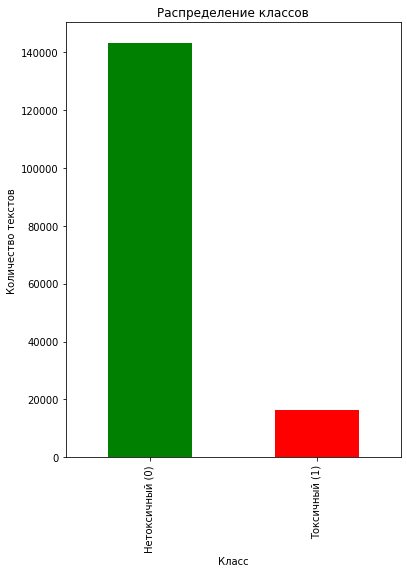

In [6]:
class_counts = data_base['toxic'].value_counts()
print(class_counts)

plt.figure(figsize=(6,8))
class_counts.plot(kind='bar', color=['green','red'])
plt.title("Распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество текстов")
plt.xticks(ticks=[0, 1], labels=['Нетоксичный (0)', 'Токсичный (1)'])
plt.show()

In [7]:
minority_class = class_counts.min()
majority_class = class_counts.max()
imbalance_ratio = majority_class / minority_class

print(f"Коэффициент дисбаланса: {imbalance_ratio:.2f}")

Коэффициент дисбаланса: 8.84


**Получаем нехилый дисбаланс таргетного фактора, важно будет учесть это при моделировании. Теперь приступим к очистке текста**

In [8]:
def clear_text(text):
    if isinstance(text, str):  # Проверяем, что text - строка
        marked = re.sub(r'[^a-zA-Z ]', ' ', text)  # Оставляем только буквы и пробелы
        return " ".join(marked.split())  # Убираем лишние пробелы
    return ""  # Если NaN или не строка, возвращаем пустую строку

In [9]:
df = data_base.copy()
df['text'] = df['text'].apply(clear_text)
print('Текст до очистки:', data_base['text'][1], '\n')
print('Текст после очистки:', df['text'][1])

Текст до очистки: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) 

Текст после очистки: D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC


**Теперь очистим от стоп-слов**

In [10]:
en_stopwords = set(stopwords.words("english"))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in en_stopwords]
    return " ".join(filtered_words)

df['text'] = df['text'].astype(str).apply(remove_stopwords)
df['text'][1]

'aww matches background colour seemingly stuck Thanks talk January UTC'

In [11]:
#text_data = " ".join(df['text'].astype(str))

# Генерируем облако слов
#wordcloud = WordCloud(background_color="white", font_path=None, width=800, height=400).generate(text_data)

#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")  # Убираем оси
#plt.show()

In [12]:
df = df.sample(n=400, random_state=RANDOM_STATE).copy()

# Взял сокращенную выборку, потому что не хватало памяти

**Инициализирую BERT**

In [13]:
model_name = "unitary/toxic-bert"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

**Разбиваем на батчи, чтобы сэкономить память**

In [14]:
def get_embeddings(texts, model, tokenizer, max_length=280):
    embeddings = []
    for text in tqdm(texts, desc="Processing texts", unit="text"):
        tokens = tokenizer.encode(text, add_special_tokens=True, max_length=max_length, truncation=True)
        padded = tokens + [0] * (max_length - len(tokens))
        attention_mask = np.where(np.array(padded) != 0, 1, 0)

        input_ids = torch.tensor([padded])
        attention_mask = torch.tensor([attention_mask])

        with torch.no_grad():
            output = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = output.hidden_states  # Скрытые состояния модели
            embedding = hidden_states[-1][:, 0, :].numpy()  # Берем [CLS] токен из последнего слоя

        embeddings.append(embedding)

    return np.vstack(embeddings)

In [15]:
texts = df['text'].tolist()
embeddings = get_embeddings(texts, model, tokenizer)

Processing texts:   0%|          | 0/400 [00:00<?, ?text/s]/tmp/ipykernel_82/3051712543.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  attention_mask = torch.tensor([attention_mask])
Processing texts: 100%|██████████| 400/400 [08:24<00:00,  1.26s/text]


**Итог: получаем готовый массив с текстами в векторном представлении, что позволит их обработать с помощью моделей**

## Обучение

**Обучаем несколько моделей на тренировочной выборке и выбираем лучшую**

In [16]:
kf = KFold(n_splits=5, shuffle=False)

In [24]:
y = df['toxic'].copy()
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, random_state=RANDOM_STATE, test_size=TEST_SIZE)

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    'SVC': SVC(class_weight='balanced', random_state=RANDOM_STATE)
}

param_grids = {
    'Logistic Regression': {
        'logisticregression__C': [0.1, 1],
        'logisticregression__penalty': ['l1', 'l2'],
        'logisticregression__solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'decisiontreeclassifier__max_depth': range(2, 10),
        'decisiontreeclassifier__min_samples_leaf': range(2, 10),
        'decisiontreeclassifier__min_samples_split': range(2, 10)
    },
    'SVC': {
        'svc__C': [0.1, 1],
        'svc__kernel': ['linear', 'rbf']
    }
}

best_model = None
best_score = 0

for model_name, model in models.items():
    print(f"Обучение модели: {model_name}")
    
    # Создаем пайплайн с SMOTE и моделью
    imba_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), model)
    
    grid_search = GridSearchCV(imba_pipeline, param_grid=param_grids[model_name], cv=kf, n_jobs=-1, verbose=1, scoring='f1')

    grid_search.fit(X_train, y_train)
    
    print(f"Лучшие параметры для {model_name}: ", grid_search.best_params_)
    
    model_score = grid_search.best_score_
    print(f"{model_name} - Кросс-валидация F1-скор: ", model_score, '\n')
    
    if model_score > best_score:
        best_model = grid_search.best_estimator_
        best_score = model_score

print(f"Лучшая модель: {best_model}")

Обучение модели: Logistic Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

Лучшие параметры для Logistic Regression:  {'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Logistic Regression - Кросс-валидация F1-скор:  0.7512820512820513 

Обучение модели: Decision Tree
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Лучшие параметры для Decision Tree:  {'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_samples_split': 6}
Decision Tree - Кросс-валидация F1-скор:  0.6418181818181818 

Обучение модели: SVC
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры для SVC:  {'svc__C': 0.1, 'svc__kernel': 'linear'}
SVC - Кросс-валидация F1-скор:  0.7046153846153846 

Лучшая модель: Pipeline(steps=[('smote', SMOTE(random_state=45)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])


In [25]:
y_pred = best_model.predict(X_test)
print("F1-скор на тестовых данных: ", round((f1_score(y_test, y_pred)), 3))

F1-скор на тестовых данных:  0.8


**Получаем, что лучшей моделью для нашей задачи опеределения токсичности текста является LogisticRegression(C=1, class_weight='balanced', max_iter=1000, solver='liblinear') с метрикой f1 = 0.8 на тестовых данных.**

## Выводы

Задачей данного проекта являлась разработка модели для классификации комментариев на позитивные и негативные для интернет-магазина «Викишоп». Важным критерием технического задания был результат метрики F1 не меньше 0.75

С точки зрения поставленной заказчиком задачи лучше всего справилась модель **LogisticRegression(C=1, class_weight='balanced', max_iter=1000, solver='liblinear') с метрикой f1 = 0.8**.

*Для поиска лучшей базовой модели был выбран метод GridSearchCV, поскольку позволяет рассмотреть большое количество комбинаций и дать точные результаты.*

*Во время проекта были подготовлены текстовые данные, далее тексты были преобразованы в векторную форму при помощи модели unitary/toxic-bert*